## Simple forecast for DESI vs eBOSS


- Setup mock data for eBOSS covariance (Chabanier et al. 2019) and DESI-lite covariance (Karacayli et al. 2020).

- Run simplest sampler with just ($\Delta_\star$, $n_\star$, $\tau_0$)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
import time

In [3]:
# specify simulation to use to generate synthetic data
test_sim_label='central'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [5]:
# specify simulation suite
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
# Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

Training GP on 270 points
Optimised


In [6]:
# Set up free parameters to be used by likelihood objects
free_param_names=["Delta2_star","n_star","ln_tau_0"]
free_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2]]
prior=None

In [9]:
def run_forecast(data_cov_label='Chabanier2019',n_burn_in=200,n_steps=500):
    # setup mock data
    data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max,
                                data_cov_label=data_cov_label)
    # setup likelihood
    like=likelihood.Likelihood(data=data,emulator=emu,
                                free_param_names=free_param_names,
                                free_param_limits=free_param_limits,
                                prior_Gauss_rms=prior)
    # setup sampler
    sampler = emcee_sampler.EmceeSampler(like=like,
                        free_param_names=free_param_names,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

    # run sampler
    start = time.time()
    sampler.run_sampler(n_burn_in,n_steps,parallel=False)
    end = time.time()
    sampler_time = end - start
    print("Sampling took {0:.1f} seconds".format(sampler_time))
    
    return sampler

In [10]:
eBOSS_sampler=run_forecast(data_cov_label='Chabanier2019')

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


100%|██████████| 700/700 [02:42<00:00,  4.30it/s]

Sampling took 162.9 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:713: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


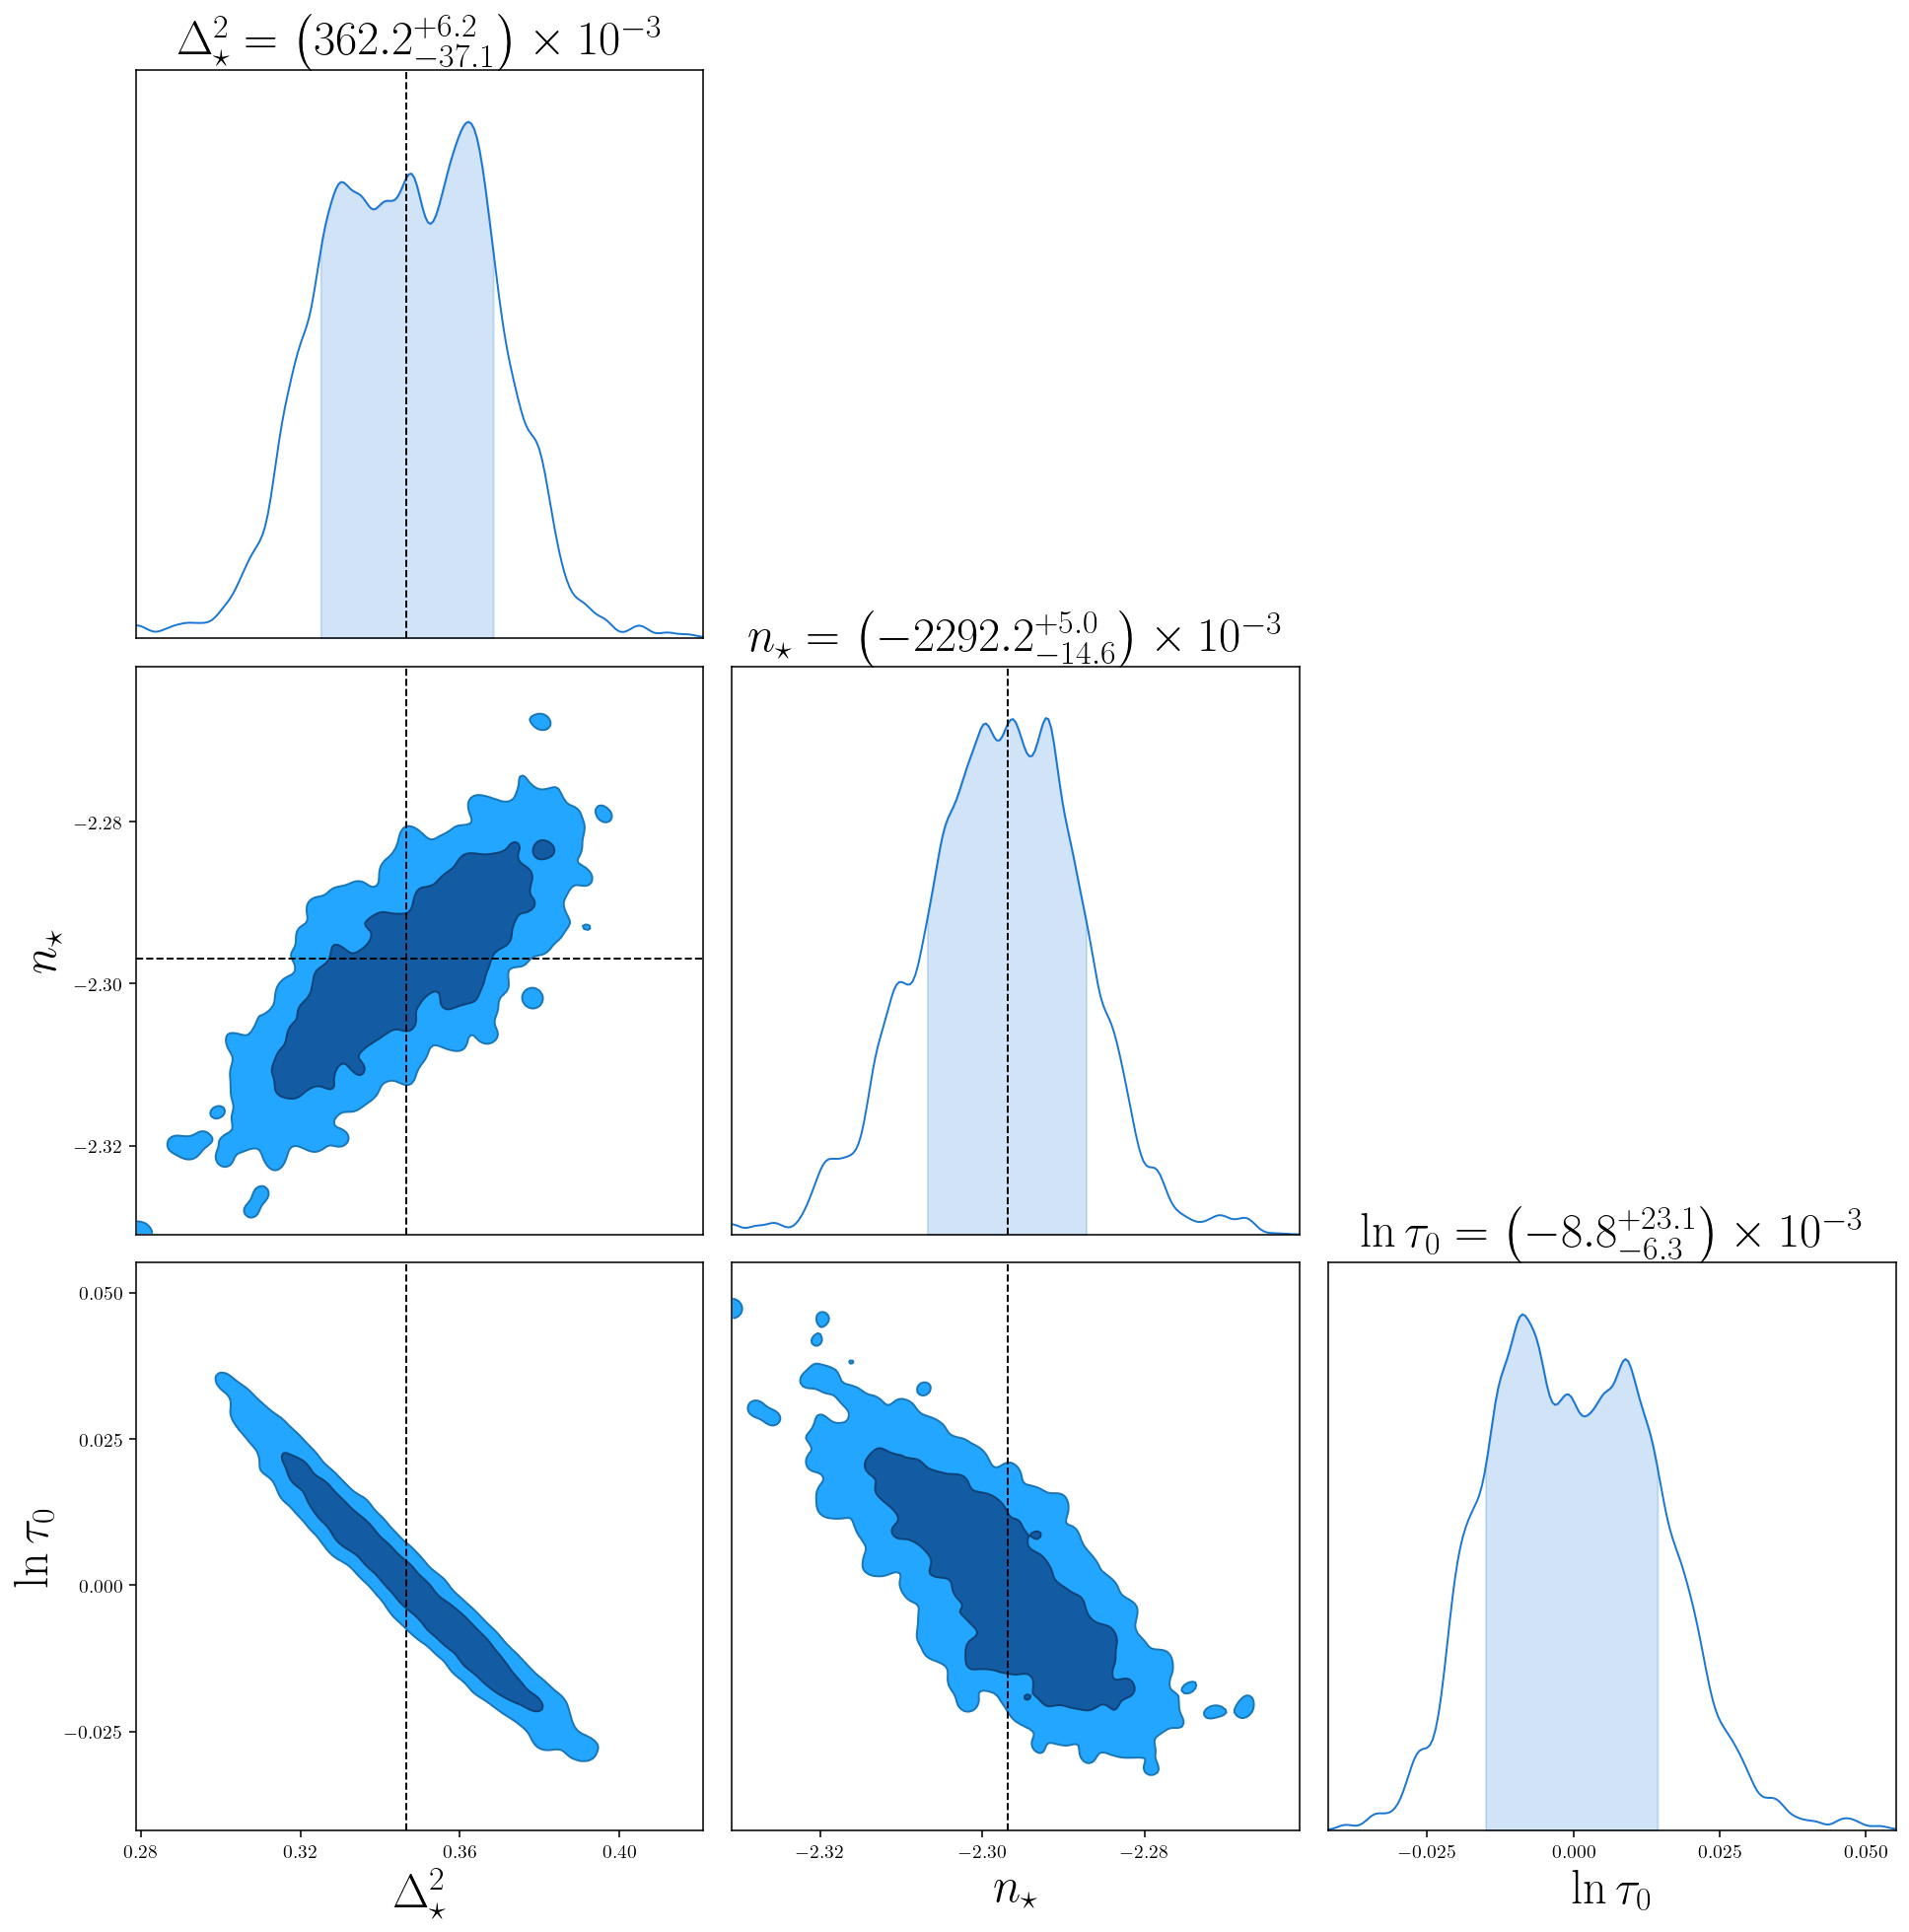

In [12]:
eBOSS_sampler.plot_corner()

In [11]:
DESI_sampler=run_forecast(data_cov_label='Karacayli_DESI')

read Nz = 12 , Nk = 19
will only use 14 k bins below 0.04
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


100%|██████████| 700/700 [03:01<00:00,  3.86it/s]

Sampling took 181.7 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:713: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


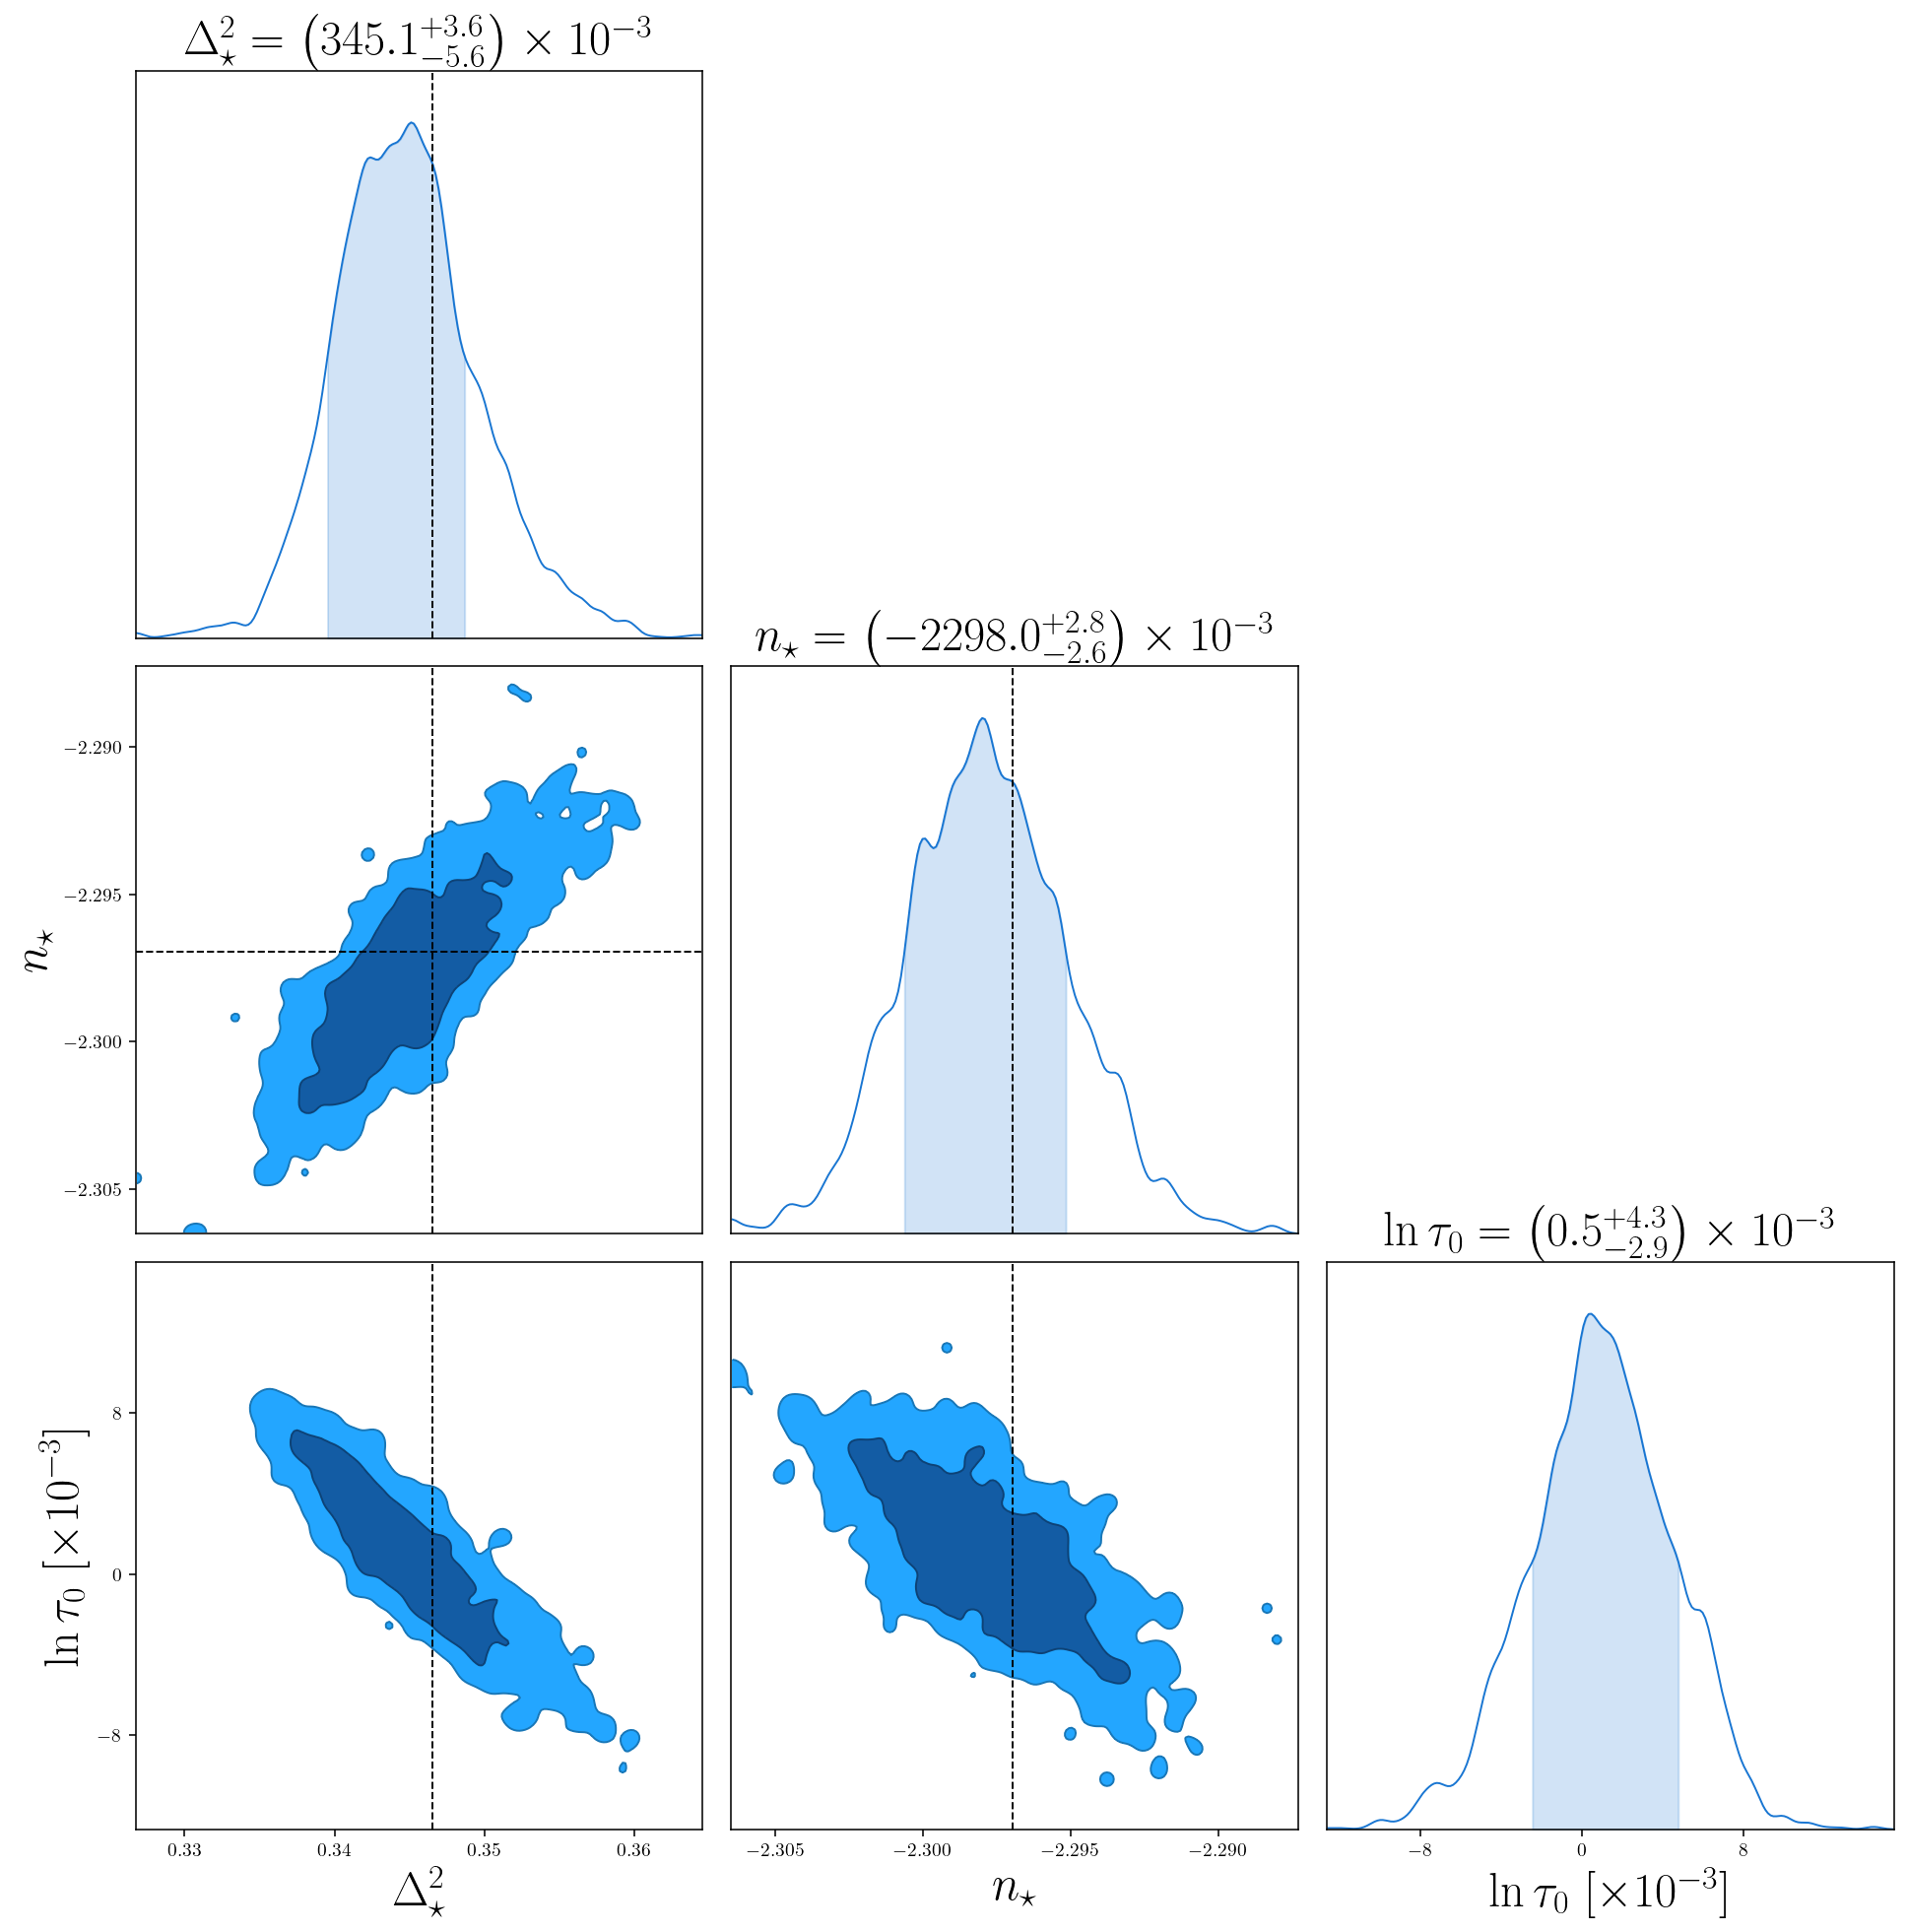

In [13]:
DESI_sampler.plot_corner()